In [ ]:
#libraries

#dataset
import pandas as pd 
import numpy as np

#text preprocessing
import re 


#ds splitting
from sklearn.model_selection import train_test_split

#feature extractiom
from sklearn.feature_extraction.text import TfidfVectorizer

#RF
from sklearn.ensemble import RandomForestClassifier

#for data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# word cloud visualization
from wordcloud import WordCloud

#performance evaluation
from sklearn.metrics import classification_report, confusion_matrix

#for saving the model
import joblib

# Enable inline plotting
%matplotlib inline

#from imblearn.over_sampling import SMOTE

from scipy import sparse



In [343]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

resource_map = {
    "tokenizers/punkt": "punkt",
    "tokenizers/punkt_tab": "punkt_tab",
    "corpora/stopwords": "stopwords",
    "corpora/wordnet": "wordnet",
    "corpora/omw-1.4": "omw-1.4",
    "taggers/averaged_perceptron_tagger": "averaged_perceptron_tagger",
    "taggers/averaged_perceptron_tagger_eng": "averaged_perceptron_tagger_eng",
    #"taggers/universal_tagset": "universal_tagset"
}

def safe_nltk_download(resource):
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(resource_map[resource])

# ensure all required resources are available
for resource in resource_map:
    safe_nltk_download(resource)

[nltk_data] Downloading package wordnet to C:\Users\Sherylle
[nltk_data]     Rose\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Sherylle
[nltk_data]     Rose\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [344]:
#uploading dataset

file_path = 'C:\\Users\\Sherylle Rose\\Desktop\\Thesis_System\\datas_labeled.csv'
data = pd.read_csv(file_path, header=None, names=['Student Sentiment', 'Classification'])

#display dataset
data.head()

,Student Sentiment,Classification
0,I feel confident using Python because it is si...,Strong
1,I still need practice with C.,Weak
2,I still need practice with Java.,Weak
3,Quite easily.,Normal
4,Basic to intermediate problems.,Strong


In [345]:
#Number of Sentiments
counts = data['Classification'].value_counts()

print("Number of Sentiment per Classification: ")
for sentiment, count in counts.items():
    print(f"{sentiment}: {count}")

Number of Sentiment per Classification: 
Normal: 548
Weak: 487
Strong: 289


In [346]:
try:
    data['Student Sentiment'] = data['Student Sentiment'].apply(text_preprocessing)
except LookupError as e:
    print("Missing resource:", e)


In [347]:
# text preprocessing

def text_preprocessing(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    text = text.lower()

    text = re.sub(r"[^a-z\s]", " ", text)  # keep only letters
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)

    # POS tagging
    word_tag_tuples = pos_tag(tokens, tagset="universal")

    # lemmatization with POS
    tag_dict = {"NOUN": "n", "VERB": "v", "ADJ": "a", "ADV": "r"}
    final_tokens = []
    for word, tag in word_tag_tuples:
        if word not in stop_words and len(word) > 1:
            if tag in tag_dict:
                final_tokens.append(lemmatizer.lemmatize(word, tag_dict[tag]))
            else:
                final_tokens.append(lemmatizer.lemmatize(word))

    return " ".join(final_tokens)

#remove missing values, remove duplicates, clean sentiments
data.dropna(inplace=True)
data = data.drop_duplicates(subset=['Student Sentiment'])
data['Student Sentiment'] = data['Student Sentiment'].apply(text_preprocessing)

data['Classification'] = data['Classification'].map({'Weak': 0, 'Normal':1, 'Strong': 2})

#display cleaned data
data.head()



,Student Sentiment,Classification
0,feel confident use python simple readable,2
1,still need practice,0
2,still need practice java,0
3,quite easily,1
4,basic intermediate problem,2


In [348]:

# Train-Test Split
X = data['Student Sentiment']
y = data['Classification']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=30
)


print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 948
Testing samples: 237


In [349]:
#number of ds for training

trainset_counts = y_train.value_counts()

print("Training set class counts:")
for sentiment, count in trainset_counts.items():
    print(f"{sentiment}: {count}")

Training set class counts:
1: 392
0: 343
2: 213


In [350]:
#feature extraction and vectorization

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Vectorized training data shape:", X_train_vec.shape)
print("Vectorized testing data shape:", X_test_vec.shape)


Vectorized training data shape: (948, 903)
Vectorized testing data shape: (237, 903)


In [351]:
nan_indices = pd.isnull(y_train)
if nan_indices.any():
    print("NaNs in y_train at indices:", y_train[nan_indices].index.tolist())
    print("NaN values:", y_train[nan_indices].values)
else:
    print("No NaNs in y_train")

No NaNs in y_train


In [ ]:
# Apply SMOTE only on training data
#smote = SMOTE(random_state=45)
#X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)


Before SMOTE:
Classification
1    392
0    343
2    213
Name: count, dtype: int64

After SMOTE:
Classification
1    392
2    392
0    392
Name: count, dtype: int64


In [353]:
#RF Training

rfmodel = RandomForestClassifier(n_estimators = 70, random_state=30)
rfmodel.fit(X_train_res, y_train_res)

print("Model Trained.")

Model Trained.


In [354]:
#RF Testing

y_pred = rfmodel.predict(X_test_vec)

print("Classification Report: ")
print(classification_report(y_test, y_pred))


Classification Report: 
              precision    recall  f1-score   support

           0       0.48      0.62      0.54        82
           1       0.60      0.47      0.53       109
           2       0.33      0.33      0.33        46

    accuracy                           0.49       237
   macro avg       0.47      0.47      0.46       237
weighted avg       0.51      0.49      0.49       237



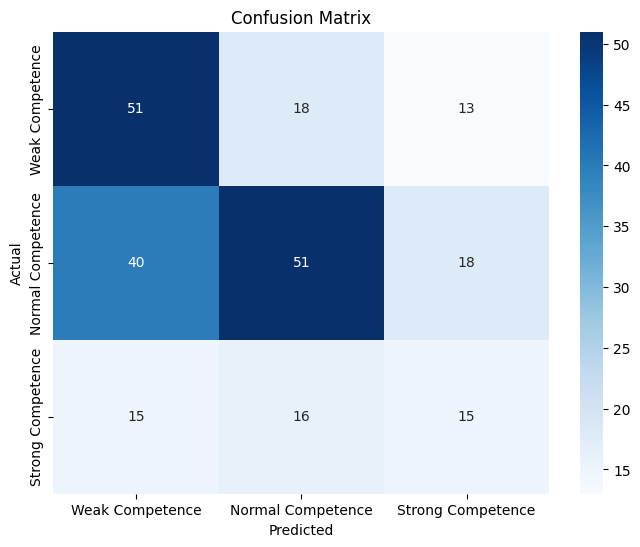

In [355]:
#Confusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Weak Competence', 'Normal Competence', 'Strong Competence'],
            yticklabels=['Weak Competence', 'Normal Competence', 'Strong Competence'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


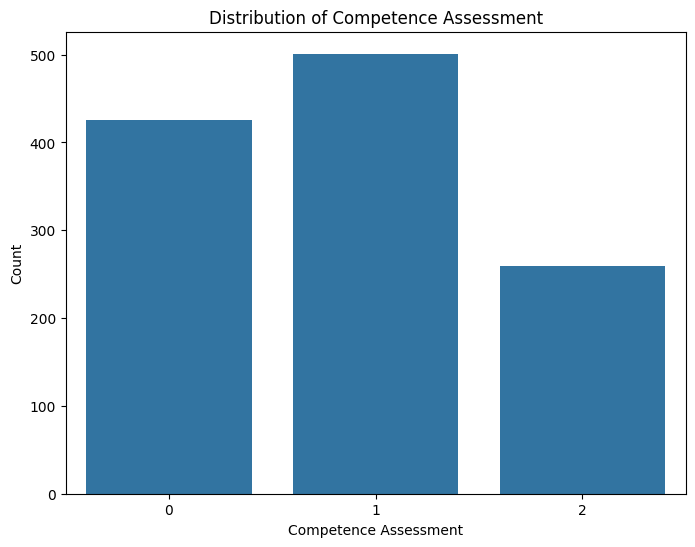

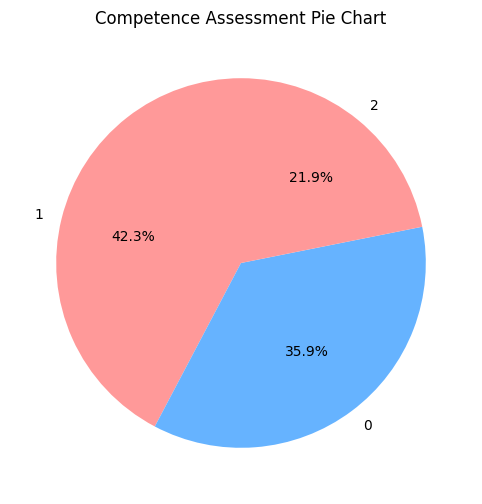

In [356]:
#Countplot

plt.figure(figsize=(8, 6))
sns.countplot(x='Classification', data=data)
plt.title('Distribution of Competence Assessment')
plt.xlabel('Competence Assessment')
plt.ylabel('Count')
plt.show()

# Pie chart
plt.figure(figsize=(8, 6))
data['Classification'].value_counts().plot.pie(
    autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title('Competence Assessment Pie Chart')
plt.ylabel('')
plt.show()


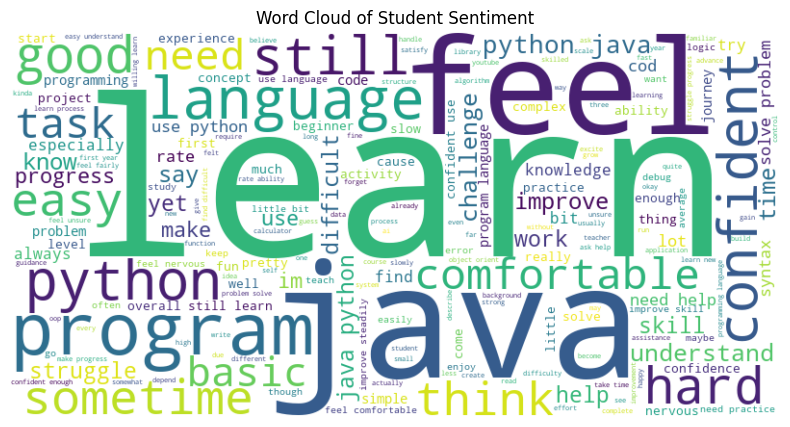

In [357]:
#Word Cloud

wordcloud = WordCloud(width=800, height=400, background_color='white') \
    .generate(' '.join(data['Student Sentiment'].astype(str)))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Student Sentiment')
plt.show()


In [358]:
import os
print(os.getcwd())

c:\Users\Sherylle Rose\Desktop\Thesis_System


In [359]:
# Save model and vectorizer

joblib.dump(rfmodel, 'random_forest_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.
